## Постановка задачи.
1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта.
2. При обучении моделей обязательно использовать кроссвалидацию.
3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики).
4. Сделать выводы о том, какая модель справилась с задачей лучше других.

In [1]:
# Нужные импорты
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix

%matplotlib inline

In [2]:
#Смотрим датасет
df = pd.read_csv('train_case2.csv', delimiter=';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


Наш trget - это столбец 'cardio'

In [3]:
#Определяем X и y
X = df.drop('cardio', axis=1)
y = df['cardio']

In [4]:
#Разбиваем данные на train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Логистическая регрессия

In [5]:
#Создаем экземпляр класса LogisticRegression
log_reg = LogisticRegression(max_iter=1000)

#Проведем кросс-валидацию
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучаем нашу модель
log_reg.fit(X_train, y_train)

CV score is 0.7527438731827463+-0.01006780734666963


LogisticRegression(max_iter=1000)

In [6]:
#Предсказываем таргетный признак
y_pred = log_reg.predict(X_test)

In [7]:
#Получим оптимальный порог (тут не понятно порог чего мы получаем!)
b=2.55
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
#Индекс максимального f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')

Best Threshold=0, F-Score=0.8831562848356244, Precision=0.5018571428571429, Recall=1.0


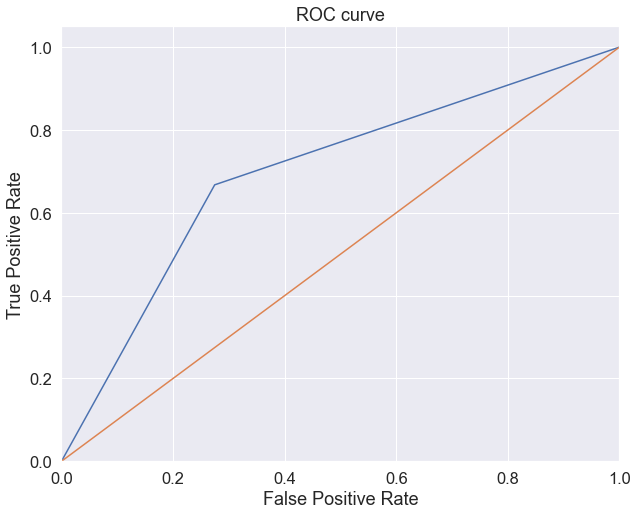

In [8]:
#Визуализируем ROC кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [9]:
#Строим матрицу ошибок
cnf_matrix = confusion_matrix(y_test, y_pred)

In [10]:
#Подготовка к визуализации матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[7588 2873]
 [3504 7035]]


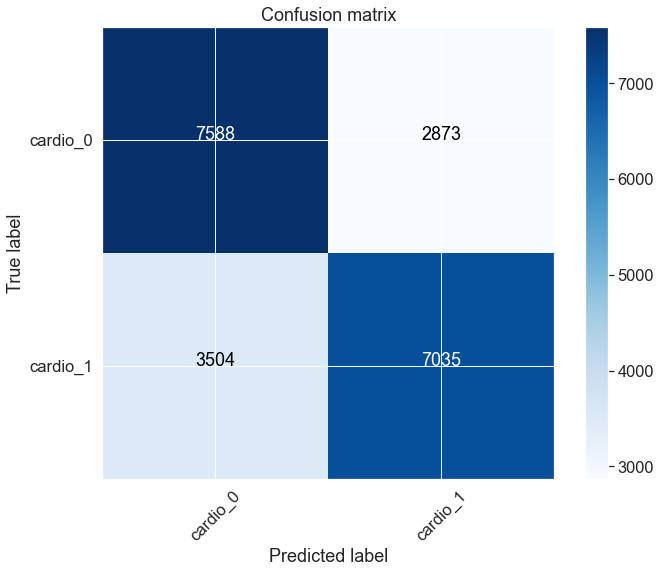

In [11]:
#Визуализипуем матрицу ошибок
plt.figure(figsize=(10, 8))
font = {'size' : 15}

plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.show()

In [14]:
precision_log_reg = precision[ix]
recall_log_reg = recall[ix]
fscore_log_reg = fscore[ix]
roc_auc_score_log_reg = roc_auc_score(y_test, y_pred)

### Дерево решений

In [28]:
#Создаем экземпляр класса DecisionTreeClassifier
des_tree = DecisionTreeClassifier(max_depth=6)

#Проведем кросс-валидацию
cv_scores = cross_val_score(des_tree, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучаем нашу модель
des_tree.fit(X_train, y_train)

CV score is 0.7918946452656775+-0.009861266567425671


DecisionTreeClassifier(max_depth=6)

In [29]:
#Предсказываем таргетный признак
y_pred = des_tree.predict(X_test)

In [30]:
#Получим оптимальный порог (тут не понятно порог чего мы получаем!)
b=2.55
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
#Индекс максимального f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')

Best Threshold=0, F-Score=0.8831562848356244, Precision=0.5018571428571429, Recall=1.0


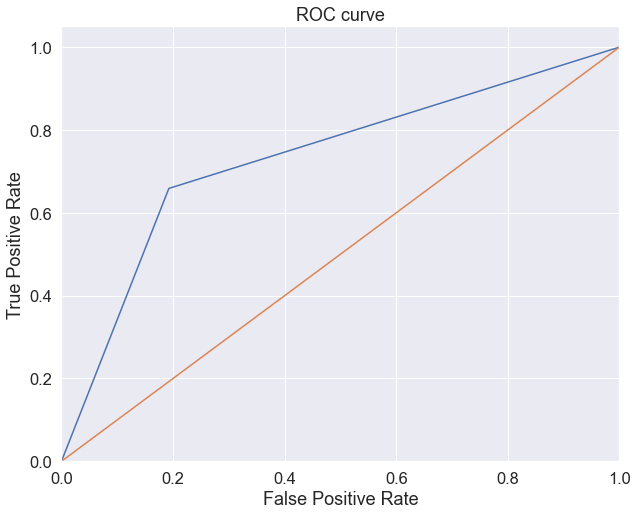

In [31]:
#Визуализируем ROC кривую
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [32]:
#Строим матрицу ошибок
cnf_matrix = confusion_matrix(y_test, y_pred)

In [33]:
#Подготовка к визуализации матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[8447 2014]
 [3595 6944]]


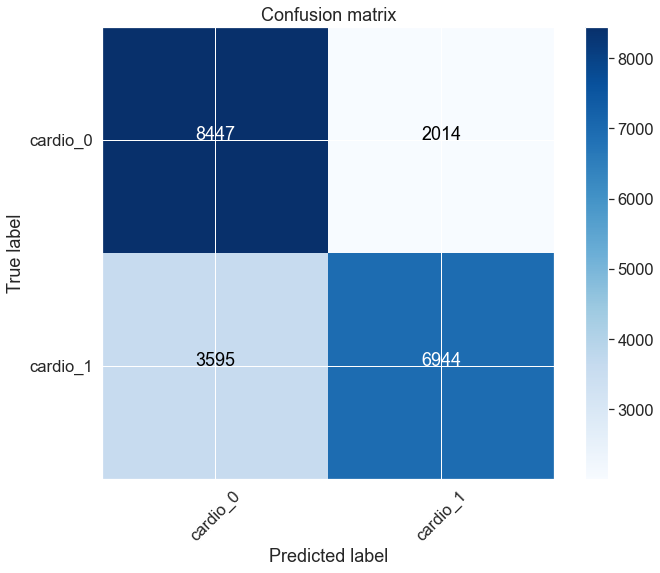

In [34]:
#Визуализипуем матрицу ошибок
plt.figure(figsize=(10, 8))
font = {'size' : 15}

plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.show()

In [35]:
precision_tree = precision[ix]
recall_tree = recall[ix]
fscore_tree = fscore[ix]
roc_auc_score_tree = roc_auc_score(y_test, y_pred)

In [36]:
score_dict = {
    'fscore': [fscore_log_reg, fscore_tree],
    'precision': [precision_log_reg, precision_tree],
    'recall': [recall_log_reg, recall_tree],
    'roc_auc_score': [roc_auc_score_log_reg, roc_auc_score_tree],
}
rows = ['log_reg', 'des_tree']
total_table = pd.DataFrame(score_dict, index=rows)
total_table

,fscore,precision,recall,roc_auc_score
log_reg,0.883156,0.501857,1.0,0.696441
des_tree,0.883156,0.501857,1.0,0.733181


Так и не понял, почему fscore, precision, recall получились одинаковыми, но при этом roc_auc_score разными. Причем матрицы ошибок тоже разные. На основании этих данных можно сказать, что алгоритм дерева отработал лучше. Игрался параметром "max_depth", при дефолтном значении дерево хуже отрабатывало.